<a href="https://colab.research.google.com/github/Jelli36/Total-FFB-Tonnage-Prediction-for-Palm-Oil-Yield/blob/main/FFB_Tonnage_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI/Final Exam/PalmOil.csv")
display(df)

,Plantation,Division,Field,long_approx,lat_approx,masl,Year_month,Year,Month,Date_Planting,...,tmin_lag27,tmin_lag28,tmin_lag29,tmin_lag30,tmin_lag31,tmin_lag32,tmin_lag33,tmin_lag34,tmin_lag35,tmin_lag36
0,Plantation 2,Division 1,Field 1,103.25,1.75,74,Jun 2006,2006,jun,Jun 2002,...,24.200001,23.500000,23.5,23.0,23.1,23.0,23.300001,23.900000,23.700001,23.800001
1,Plantation 7,Division 2,Field 2,100.75,5.75,23,Jul 2006,2006,jul,Mar 2000,...,23.100000,22.900000,21.9,22.0,21.9,22.1,22.000000,22.300001,22.800001,22.500000
2,Plantation 7,Division 2,Field 3,100.75,5.75,23,Jul 2006,2006,jul,Nov 2000,...,23.100000,22.900000,21.9,22.0,21.9,22.1,22.000000,22.300001,22.800001,22.500000
3,Plantation 7,Division 3,Field 4,100.75,5.75,31,Jul 2006,2006,jul,Mar 2000,...,23.100000,22.900000,21.9,22.0,21.9,22.1,22.000000,22.300001,22.800001,22.500000
4,Plantation 2,Division 1,Field 5,103.25,1.75,74,Jul 2006,2006,jul,May 2002,...,23.900000,24.200001,23.5,23.5,23.0,23.1,23.000000,23.300001,23.900000,23.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9728,Plantation 8,Division 20,Field 46,117.75,4.25,24,Jun 2017,2017,jun,Sep 2002,...,23.200001,22.900000,23.1,23.4,23.5,22.9,22.700001,22.300001,22.900000,23.500000
9729,Plantation 8,Division 20,Field 48,117.75,4.25,24,Jun 2017,2017,jun,Dec 2002,...,23.200001,22.900000,23.1,23.4,23.5,22.9,22.700001,22.300001,22.900000,23.500000
9730,Plantation 8,Division 20,Field 65,117.75,4.25,24,Jun 2017,2017,jun,May 2004,...,23.200001,22.900000,23.1,23.4,23.5,22.9,22.700001,22.300001,22.900000,23.500000
9731,Plantation 8,Division 20,Field 66,117.75,4.25,24,Jun 2017,2017,jun,May 2004,...,23.200001,22.900000,23.1,23.4,23.5,22.9,22.700001,22.300001,22.900000,23.500000


In [4]:
# Drop duplicated items
print(f"Number of duplicates: {np.sum(df.duplicated())}")

df.drop_duplicates(inplace = True)

print(f"Number of duplicates after: {np.sum(df.duplicated())}")

Number of duplicates: 0
Number of duplicates after: 0


In [5]:
# Check for null values
df.isnull().sum()

,0
Plantation,0
Division,0
Field,0
long_approx,0
lat_approx,0
...,...
tmin_lag32,0
tmin_lag33,0
tmin_lag34,0
tmin_lag35,0


In [6]:
# Extract the 'field', 'plantation', 'division', and 'year_planted' from the 'Field', 'Plantation','Division', 'Date_Planting' column to get only the numbers
df['field'] = df['Field'].str.extract(r'Field (\d+)')
df['plantation'] = df['Plantation'].str.extract(r'Plantation (\d+)')
df['division'] = df['Division'].str.extract(r'Division (\d+)')
df['year_planted'] = df['Date_Planting'].str.extract(r'(\d{4})')

# Convert extracted columns into int data type
df['field'] = df['field'].astype(int)
df['plantation'] = df['plantation'].astype(int)
df['division'] = df['division'].astype(int)
df['year_planted'] = df['year_planted'].astype(int)

# Drop the original columns if it's no longer needed as well as other columns that are irrelevant
df.drop(columns=['Field', 'Plantation','Division', 'Date_Planting', 'Month','Year_month','start','end', 'ann.start','ann.end'], axis = 1, inplace = True)

In [7]:
display(df)

,long_approx,lat_approx,masl,Year,Age_y,Total.FFB.Tonnage,Hectrage,yield_tha,timespan,Rainfall_mm,...,tmin_lag31,tmin_lag32,tmin_lag33,tmin_lag34,tmin_lag35,tmin_lag36,field,plantation,division,year_planted
0,103.25,1.75,74,2006,4,37.850,59.19,0.639466,11.000000,177.0,...,23.1,23.0,23.300001,23.900000,23.700001,23.800001,1,2,1,2002
1,100.75,5.75,23,2006,6,496.410,163.97,3.027444,10.916667,157.0,...,21.9,22.1,22.000000,22.300001,22.800001,22.500000,2,7,2,2000
2,100.75,5.75,23,2006,5,165.610,101.65,1.629218,10.916667,157.0,...,21.9,22.1,22.000000,22.300001,22.800001,22.500000,3,7,2,2000
3,100.75,5.75,31,2006,6,430.460,131.70,3.268489,10.916667,157.0,...,21.9,22.1,22.000000,22.300001,22.800001,22.500000,4,7,3,2000
4,103.25,1.75,74,2006,4,56.060,77.40,0.724289,10.916667,56.0,...,23.0,23.1,23.000000,23.300001,23.900000,23.700001,5,2,1,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9728,117.75,4.25,24,2017,14,112.215,82.18,1.365478,10.750000,38.0,...,23.5,22.9,22.700001,22.300001,22.900000,23.500000,46,8,20,2002
9729,117.75,4.25,24,2017,14,124.295,75.23,1.652200,10.500000,38.0,...,23.5,22.9,22.700001,22.300001,22.900000,23.500000,48,8,20,2002
9730,117.75,4.25,24,2017,13,133.256,72.46,1.839028,9.083333,38.0,...,23.5,22.9,22.700001,22.300001,22.900000,23.500000,65,8,20,2004
9731,117.75,4.25,24,2017,13,155.728,94.46,1.648613,9.083333,38.0,...,23.5,22.9,22.700001,22.300001,22.900000,23.500000,66,8,20,2004


In [8]:
# Compute the correlation matrix
corr_matrix = df.drop(['field', 'plantation', 'division', 'year_planted','Age_y', 'Total.FFB.Tonnage'], axis = 1).corr()

# Find columns with high correlation (>= 0.7 or <= -0.7)
columns_to_drop = corr_matrix.columns[
    corr_matrix.apply(lambda x: (x.abs() >= 0.7) & (x != 1)).any()
    ].tolist()

# Drop columns with high correlation to avoid overfitting, multicollinearity, and inefficiency
df = df.drop(columns=columns_to_drop)

print(corr_matrix)
print(columns_to_drop)
display(df)

             long_approx  lat_approx      masl      Year  Hectrage  yield_tha  \
long_approx     1.000000    0.210496 -0.129937 -0.010312  0.096369   0.004694   
lat_approx      0.210496    1.000000  0.053839  0.001756 -0.023418   0.016341   
masl           -0.129937    0.053839  1.000000 -0.002771 -0.164809  -0.277800   
Year           -0.010312    0.001756 -0.002771  1.000000 -0.108165  -0.021329   
Hectrage        0.096369   -0.023418 -0.164809 -0.108165  1.000000  -0.068901   
...                  ...         ...       ...       ...       ...        ...   
tmin_lag32      0.100789   -0.554979 -0.576082  0.111386  0.185076  -0.000048   
tmin_lag33      0.101751   -0.554580 -0.575501  0.127785  0.185149  -0.023791   
tmin_lag34      0.101547   -0.554628 -0.575178  0.139602  0.184927  -0.031075   
tmin_lag35      0.102988   -0.554330 -0.575032  0.138677  0.185140  -0.013767   
tmin_lag36      0.103885   -0.553974 -0.574977  0.132005  0.185495   0.003129   

             timespan  Rain

,long_approx,lat_approx,masl,Year,Age_y,Total.FFB.Tonnage,Hectrage,yield_tha,timespan,Rainfall_mm,...,Rainfall_mm_lag31,Rainfall_mm_lag32,Rainfall_mm_lag33,Rainfall_mm_lag34,Rainfall_mm_lag35,Rainfall_mm_lag36,field,plantation,division,year_planted
0,103.25,1.75,74,2006,4,37.850,59.19,0.639466,11.000000,177.0,...,303.0,244.0,97.0,184.0,28.0,125.0,1,2,1,2002
1,100.75,5.75,23,2006,6,496.410,163.97,3.027444,10.916667,157.0,...,93.0,400.0,916.0,217.0,208.0,155.0,2,7,2,2000
2,100.75,5.75,23,2006,5,165.610,101.65,1.629218,10.916667,157.0,...,93.0,400.0,916.0,217.0,208.0,155.0,3,7,2,2000
3,100.75,5.75,31,2006,6,430.460,131.70,3.268489,10.916667,157.0,...,93.0,400.0,916.0,217.0,208.0,155.0,4,7,3,2000
4,103.25,1.75,74,2006,4,56.060,77.40,0.724289,10.916667,56.0,...,142.0,303.0,244.0,97.0,184.0,28.0,5,2,1,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9728,117.75,4.25,24,2017,14,112.215,82.18,1.365478,10.750000,38.0,...,568.0,221.0,252.0,41.0,242.0,129.0,46,8,20,2002
9729,117.75,4.25,24,2017,14,124.295,75.23,1.652200,10.500000,38.0,...,568.0,221.0,252.0,41.0,242.0,129.0,48,8,20,2002
9730,117.75,4.25,24,2017,13,133.256,72.46,1.839028,9.083333,38.0,...,568.0,221.0,252.0,41.0,242.0,129.0,65,8,20,2004
9731,117.75,4.25,24,2017,13,155.728,94.46,1.648613,9.083333,38.0,...,568.0,221.0,252.0,41.0,242.0,129.0,66,8,20,2004


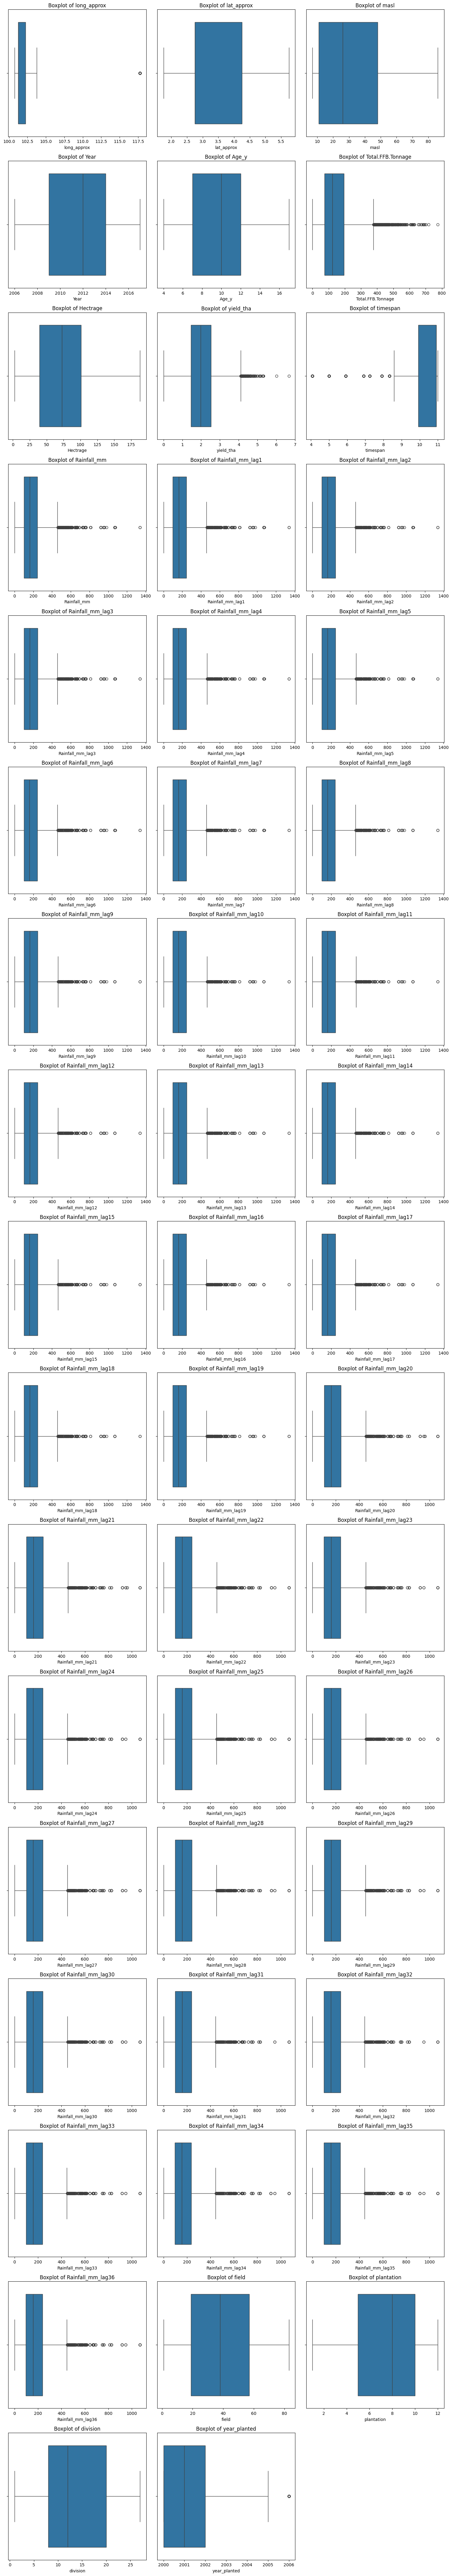

In [9]:
# Get all column names
numeric_columns = df.columns

# Calculate the grid size
num_columns = len(numeric_columns)
grid_rows = math.ceil(num_columns / 3)  # Number of rows needed for a 3-column grid

# Create boxplots
plt.figure(figsize=(15, 5 * grid_rows))  # Adjust figure height based on rows

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(grid_rows, 3, i)  # Dynamically adjust subplot positions
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [10]:
# Using quantile to get rid of outliers to lessen skew
df = df[df['long_approx'] < df['long_approx'].quantile(0.95)]
df = df[df['yield_tha'] < df['yield_tha'].quantile(0.95)]
df = df[df['Total.FFB.Tonnage'] < df['Total.FFB.Tonnage'].quantile(0.95)]
df = df[df['timespan'] < df['timespan'].quantile(0.95)]
df = df[df['Rainfall_mm'] < df['Rainfall_mm'].quantile(0.95)]
df = df[df['Rainfall_mm_lag1'] < df['Rainfall_mm_lag1'].quantile(0.95)]
df = df[df['Rainfall_mm_lag2'] < df['Rainfall_mm_lag2'].quantile(0.95)]
df = df[df['Rainfall_mm_lag3'] < df['Rainfall_mm_lag3'].quantile(0.95)]
df = df[df['Rainfall_mm_lag4'] < df['Rainfall_mm_lag4'].quantile(0.95)]
df = df[df['Rainfall_mm_lag5'] < df['Rainfall_mm_lag5'].quantile(0.95)]
df = df[df['Rainfall_mm_lag6'] < df['Rainfall_mm_lag6'].quantile(0.95)]
df = df[df['Rainfall_mm_lag7'] < df['Rainfall_mm_lag7'].quantile(0.95)]
df = df[df['Rainfall_mm_lag8'] < df['Rainfall_mm_lag8'].quantile(0.95)]
df = df[df['Rainfall_mm_lag9'] < df['Rainfall_mm_lag9'].quantile(0.95)]
df = df[df['Rainfall_mm_lag10'] < df['Rainfall_mm_lag10'].quantile(0.95)]
df = df[df['Rainfall_mm_lag11'] < df['Rainfall_mm_lag11'].quantile(0.95)]
df = df[df['Rainfall_mm_lag12'] < df['Rainfall_mm_lag12'].quantile(0.95)]
df = df[df['Rainfall_mm_lag13'] < df['Rainfall_mm_lag13'].quantile(0.95)]
df = df[df['Rainfall_mm_lag14'] < df['Rainfall_mm_lag14'].quantile(0.95)]
df = df[df['Rainfall_mm_lag15'] < df['Rainfall_mm_lag15'].quantile(0.95)]
df = df[df['Rainfall_mm_lag16'] < df['Rainfall_mm_lag16'].quantile(0.95)]
df = df[df['Rainfall_mm_lag17'] < df['Rainfall_mm_lag17'].quantile(0.95)]
df = df[df['Rainfall_mm_lag18'] < df['Rainfall_mm_lag18'].quantile(0.95)]
df = df[df['Rainfall_mm_lag19'] < df['Rainfall_mm_lag19'].quantile(0.95)]
df = df[df['Rainfall_mm_lag20'] < df['Rainfall_mm_lag20'].quantile(0.95)]
df = df[df['Rainfall_mm_lag21'] < df['Rainfall_mm_lag21'].quantile(0.95)]
df = df[df['Rainfall_mm_lag22'] < df['Rainfall_mm_lag22'].quantile(0.95)]
df = df[df['Rainfall_mm_lag23'] < df['Rainfall_mm_lag23'].quantile(0.95)]
df = df[df['Rainfall_mm_lag24'] < df['Rainfall_mm_lag24'].quantile(0.95)]
df = df[df['Rainfall_mm_lag25'] < df['Rainfall_mm_lag25'].quantile(0.95)]
df = df[df['Rainfall_mm_lag26'] < df['Rainfall_mm_lag26'].quantile(0.95)]
df = df[df['Rainfall_mm_lag27'] < df['Rainfall_mm_lag27'].quantile(0.95)]
df = df[df['Rainfall_mm_lag28'] < df['Rainfall_mm_lag28'].quantile(0.95)]
df = df[df['Rainfall_mm_lag29'] < df['Rainfall_mm_lag29'].quantile(0.95)]
df = df[df['Rainfall_mm_lag30'] < df['Rainfall_mm_lag30'].quantile(0.95)]
df = df[df['Rainfall_mm_lag31'] < df['Rainfall_mm_lag31'].quantile(0.95)]
df = df[df['Rainfall_mm_lag32'] < df['Rainfall_mm_lag32'].quantile(0.95)]
df = df[df['Rainfall_mm_lag33'] < df['Rainfall_mm_lag33'].quantile(0.95)]
df = df[df['Rainfall_mm_lag34'] < df['Rainfall_mm_lag34'].quantile(0.95)]
df = df[df['Rainfall_mm_lag35'] < df['Rainfall_mm_lag35'].quantile(0.95)]
df = df[df['Rainfall_mm_lag36'] < df['Rainfall_mm_lag36'].quantile(0.95)]

In [11]:
# Use one-hot encoding to convert the following columns
df = pd.get_dummies(df, columns = ['field', 'plantation', 'division'], drop_first = True)

In [12]:
display(df)

,long_approx,lat_approx,masl,Year,Age_y,Total.FFB.Tonnage,Hectrage,yield_tha,timespan,Rainfall_mm,...,division_6,division_8,division_10,division_11,division_13,division_15,division_21,division_24,division_25,division_26
243,101.25,2.75,9,2006,4,50.060,56.48,0.886331,10.583333,157.0,...,False,True,False,False,False,False,False,False,False,False
251,101.25,2.75,10,2006,4,49.970,46.88,1.065913,10.750000,157.0,...,False,False,True,False,False,False,False,False,False,False
291,101.25,2.75,9,2007,4,100.840,56.48,1.785411,10.583333,167.0,...,False,True,False,False,False,False,False,False,False,False
299,101.25,2.75,10,2007,4,73.290,46.88,1.563353,10.750000,167.0,...,False,False,True,False,False,False,False,False,False,False
339,101.25,2.75,9,2007,4,86.400,56.48,1.529745,10.583333,30.0,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,101.25,2.75,10,2016,14,72.308,39.37,1.836627,10.750000,330.0,...,False,False,True,False,False,False,False,False,False,False
9243,101.25,2.75,10,2016,14,58.365,39.37,1.482474,10.750000,273.0,...,False,False,True,False,False,False,False,False,False,False
9318,101.25,2.75,10,2017,14,104.094,39.37,2.643993,10.750000,224.0,...,False,False,True,False,False,False,False,False,False,False
9393,101.25,2.75,10,2017,14,72.609,39.37,1.844272,10.750000,164.0,...,False,False,True,False,False,False,False,False,False,False


In [13]:
# Identify the features (X) and the target (y)
X = df.drop(['Total.FFB.Tonnage'], axis = 1).values
y = df['Total.FFB.Tonnage'].values

In [14]:
print(X.shape, y.shape)

(534, 85) (534,)


In [15]:
# Use standard scaler to give the same importance to every feature
scaler = StandardScaler()

X = scaler.fit_transform(X)
y = y.reshape(-1,1)
y = scaler.fit_transform(y).flatten()

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Initialize the models to be used with their hyperparameters
rf = RandomForestRegressor(n_estimators = 200, random_state=42)
xgb = XGBRegressor(n_estimators = 200, random_state=42)
lgbm = LGBMRegressor(n_estimators = 200, random_state=42)

In [18]:
# Compare models
models = {'Random Forest': rf, 'XGBoost': xgb, 'LightGBM': lgbm}
results = {}

for name, model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name} -> Mean Squared Error: {metrics['MSE']:.4f}, R-squared: {metrics['R2']:.4f}")

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation MSE (mean):", -np.mean(cv_scores))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4173
[LightGBM] [Info] Number of data points in the train set: 427, number of used features: 65
[LightGBM] [Info] Start training from score 0.051086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

<ipython-input-19-af9db40e0111>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


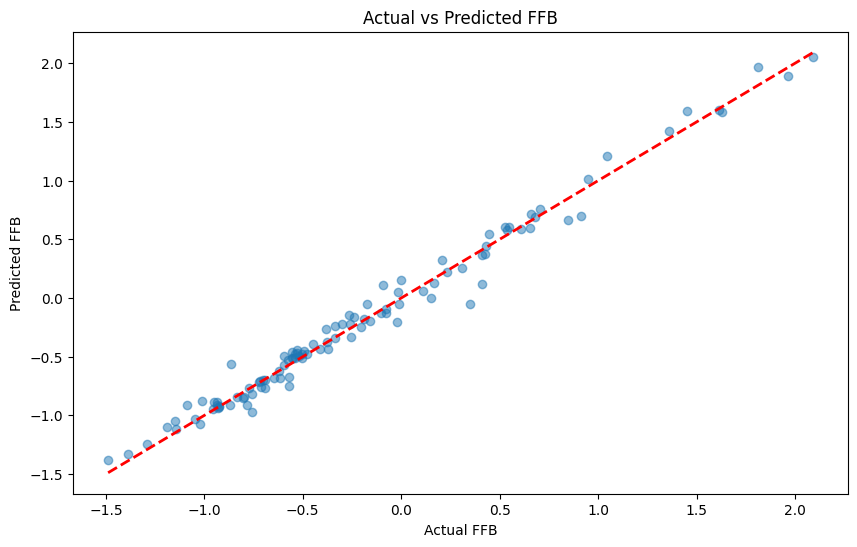

In [19]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Actual FFB')
plt.ylabel('Predicted FFB')
plt.title('Actual vs Predicted FFB')
plt.show()

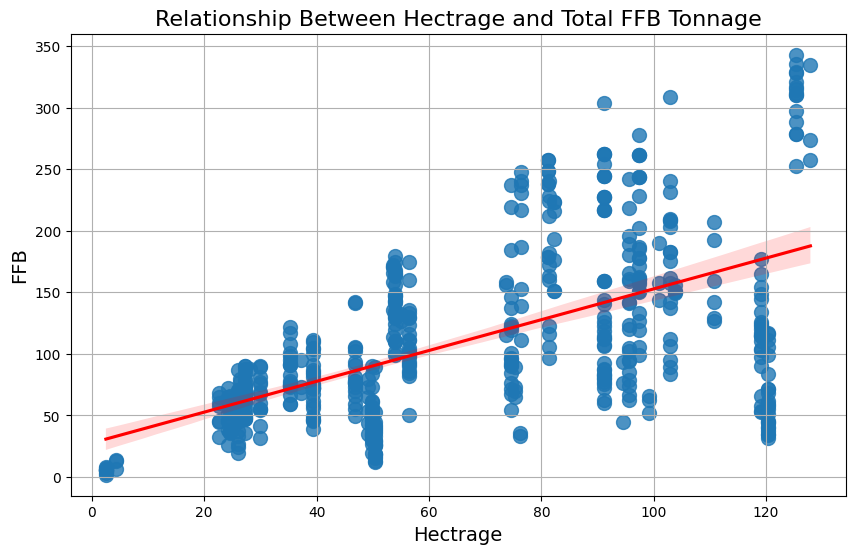

In [20]:
# Scatter plot to visualize the relationship between Hectrage and Total FFB Tonnage

plt.figure(figsize=(10, 6))
sns.regplot(x='Hectrage', y='Total.FFB.Tonnage', data=df, scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title('Relationship Between Hectrage and Total FFB Tonnage', fontsize=16)
plt.xlabel('Hectrage', fontsize=14)
plt.ylabel('FFB', fontsize=14)
plt.grid(True)
plt.show()